# Exploratory Data Analysis (EDA) - Enriched

### Preparations

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyspark.sql.functions as sf

plt.style.use('bmh')
pd.options.display.max_columns = 500

In [2]:
# Broadcasts and streams
poms = spark.read.parquet("gs://dataproc-jupyter-eileen.npo-data.nl/data/poms_sub/")
print(poms.count())
poms.printSchema()

84835
root
 |-- age_rating: string (nullable = true)
 |-- credits: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- family_name: string (nullable = true)
 |    |    |-- given_name: string (nullable = true)
 |    |    |-- role: string (nullable = true)
 |-- genres: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: string (nullable = true)
 |    |    |-- terms: array (nullable = true)
 |    |    |    |-- element: string (containsNull = true)
 |-- mid: string (nullable = true)
 |-- sortDate: string (nullable = true)
 |-- broadcaster: string (nullable = true)
 |-- description: string (nullable = true)
 |-- title: string (nullable = true)
 |-- sub: string (nullable = true)



In [3]:
def replace(column, value):
    return sf.when(sf.size(column) > value, column).otherwise(sf.lit(None))
def replace2(column, value):
    return sf.when(column != value, column).otherwise(sf.lit(None))

poms = poms.withColumn("credits", replace(sf.col("credits"), 0))
poms = poms.withColumn("genres", replace(sf.col("genres"), 0))
poms = poms.withColumn("sub", replace2(sf.col("sub"), ""))

df = poms.toPandas()

In [4]:
df.head()

,age_rating,credits,genres,mid,sortDate,broadcaster,description,title,sub
0,ALL,None,"[(3.0.1.6, [Amusement]), (3.0.1.7, [Informatie...",NCRV_1542213,2012-08-06 09:00:00 UTC,NCRV,-Stellen. -Yoga met. -Asia goes Dutch (4). -Si...,Kijk op themakanaal Spirit 24,None
1,ALL,"[(Freriks, Philip, PRESENTER), (Rossem, Maarte...","[(3.0.1.6, [Amusement])]",NCRV_1616517,2013-08-06 18:25:00 UTC,NCRV,Kennisquiz met een knipoog.,De slimste mens,888 wie kent de steden van europa... en weet w...
2,12,None,"[(3.0.1.6, [Amusement])]",BV_101386853,2018-08-11 23:35:00 UTC,BNVA,Hoogtepunten van het digitale jongerenkanaal 1...,Het Beste van NPO3 Extra,888 tegenwoordig heeft iedereen last van burn-...
3,ALL,None,"[(3.0.1.1, [Jeugd]), (3.0.1.7.21, [Informatief...",POW_00421885,2012-03-31 16:45:00 UTC,NOS,None,NOS Jeugdjournaal,None
4,ALL,None,"[(3.0.1.7.21, [Informatief, Nieuws/actualiteit...",POW_03684384,2018-10-11 05:00:00 UTC,NOS,Met het laatste nieuws en de weersverwachting.,NOS Journaal met gebarentolk,"888 lokaal valt een buitje, verder is het vrij..."


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84835 entries, 0 to 84834
Data columns (total 9 columns):
age_rating     84835 non-null object
credits        30765 non-null object
genres         73179 non-null object
mid            84835 non-null object
sortDate       84835 non-null object
broadcaster    84835 non-null object
description    71521 non-null object
title          84835 non-null object
sub            35153 non-null object
dtypes: object(9)
memory usage: 5.8+ MB


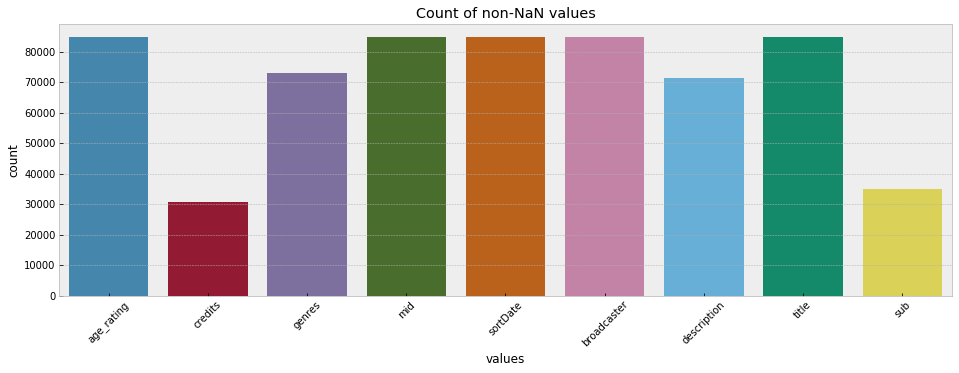

In [6]:
test = df.isna().sum()
df2 = pd.DataFrame({'values':test.index, 'na_count':test.values})
df2['count'] = poms.count() - df2['na_count']

plt.figure(figsize = (16,5))
ax = sns.barplot(x='values', y ='count', data=df2).set_title('Count of non-NaN values')
plt.xticks(rotation=45)
plt.show()

### Visualizing data distribution

In [7]:
df['age_rating'] = df['age_rating'].astype('category')
df['credits'] = df['credits'].astype('string').astype('category')
df['genres'] = df['genres'].astype('string').astype('category')
df['broadcaster'] = df['broadcaster'].astype('category')
df.dtypes

age_rating     category
credits        category
genres         category
mid              object
sortDate         object
broadcaster    category
description      object
title            object
sub              object
dtype: object

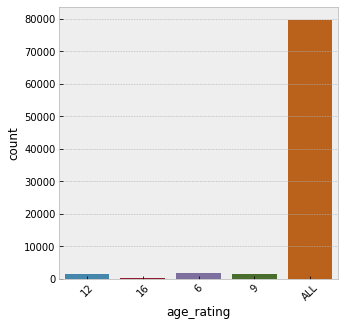

In [8]:
plt.figure(figsize = (5,5))
ax = sns.countplot(x="age_rating", data=df)
plt.xticks(rotation=45)
plt.show()

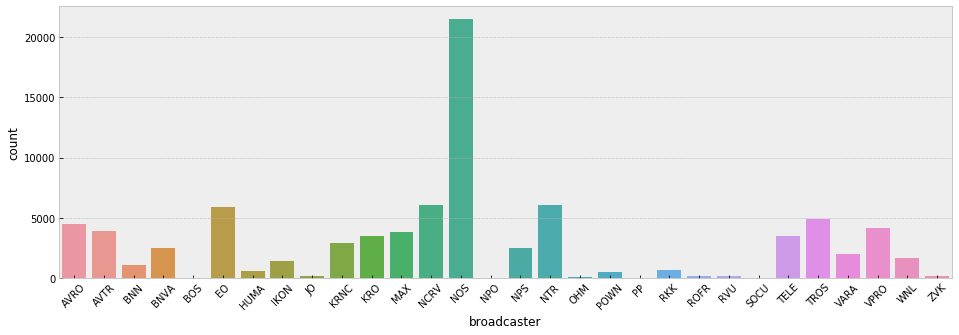

In [9]:
plt.figure(figsize = (16,5))
ax = sns.countplot(x="broadcaster", data=df)
plt.xticks(rotation=45)
plt.show()

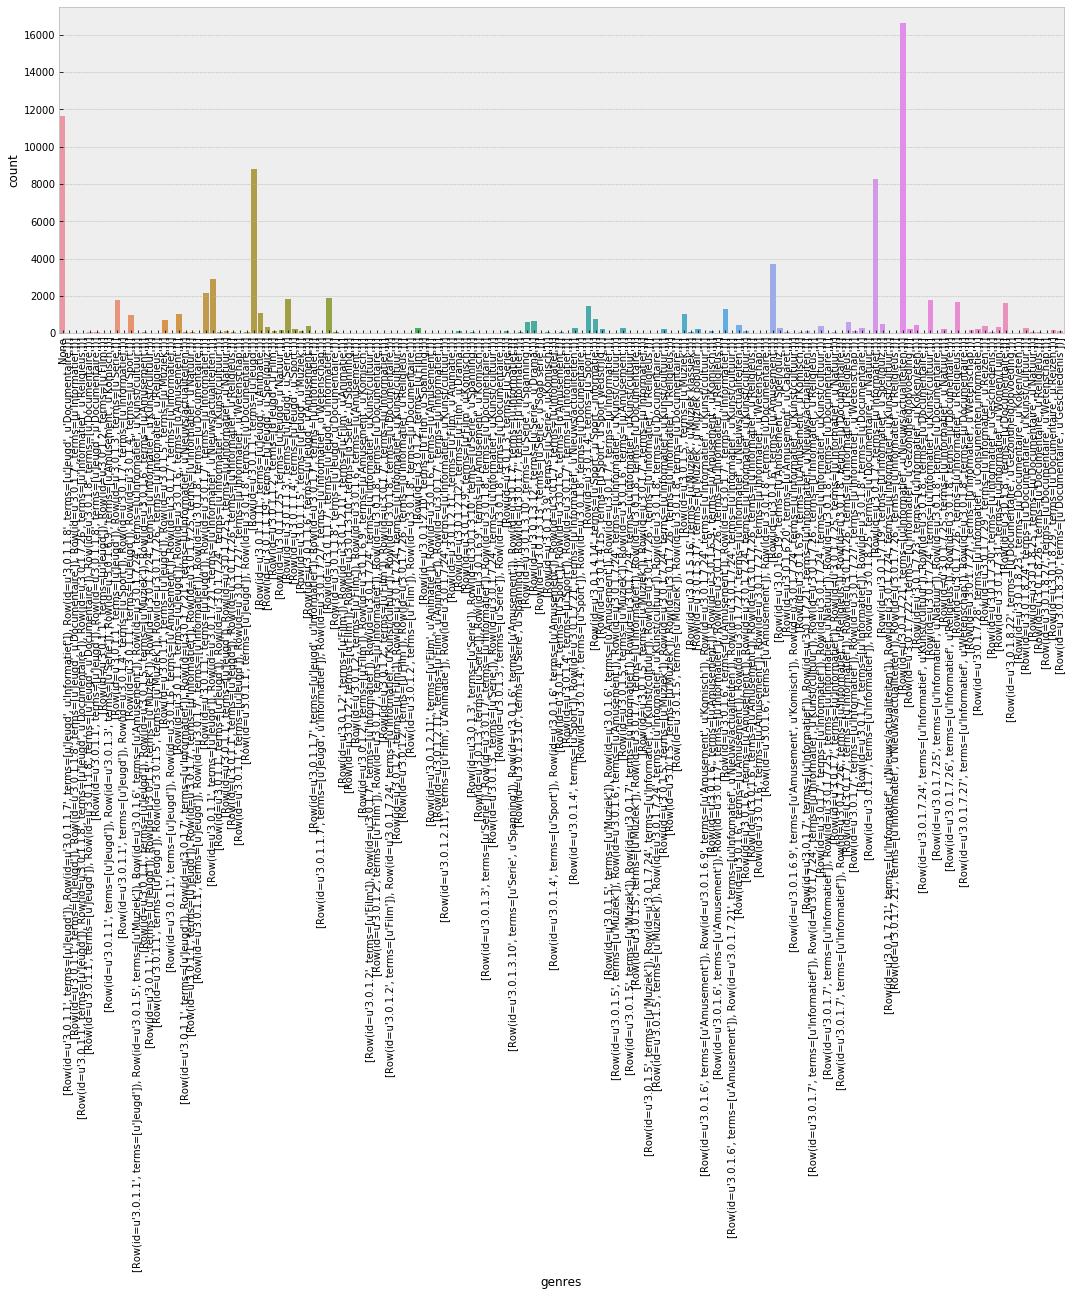

In [10]:
plt.figure(figsize = (18,6))
ax = sns.countplot(x="genres", data=df)
plt.xticks(rotation=90)
plt.show()

## Text length (includes 0 values)

In [11]:
# amount of characters, not words
df['title_length'] = df.title.str.len() 
df['description_length'] = df.description.str.len()
df['title_length'] = df['title_length'].fillna(0)
df['description_length'] = df['description_length'].fillna(0)

In [12]:
print("Mean " + str(df['title_length'].mean()))
print("Median " + str(df['title_length'].median()))

Mean 15.5762244357
Median 13.0


/opt/conda/anaconda/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


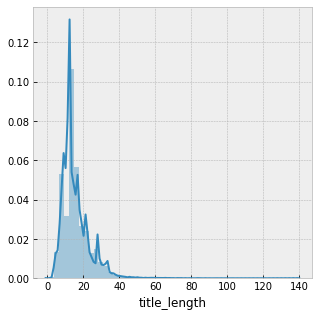

In [13]:
plt.figure(figsize=(5,5))
sns.distplot(df['title_length'])

In [14]:
print("Mean " + str(df['description_length'].mean()))
print("Median " + str(df['description_length'].median()))

Mean 131.09338127
Median 117.0


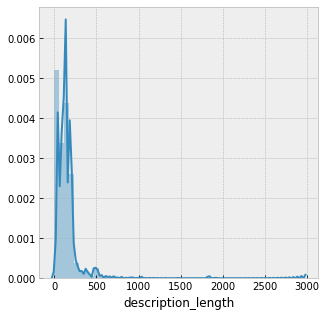

In [15]:
plt.figure(figsize=(5,5))
sns.distplot(df['description_length'])

In [16]:
df['sub_length'] = df['sub'].str.len() 
df['sub_length'] = df['sub_length'].fillna(0)

In [17]:
print("Mean " + str(df['sub_length'].mean()))
print("Median " + str(df['sub_length'].median()))

Mean 5881.11075617
Median 0.0


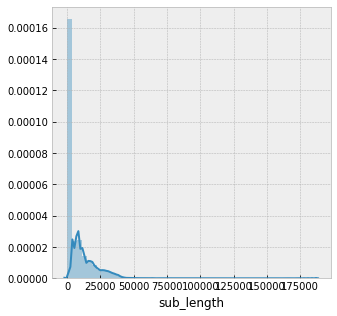

In [18]:
plt.figure(figsize=(5,5))
sns.distplot(df['sub_length']) 

- Title, description and subtitle (character) length al have a skewed distribution

### Broadcaster richness investigation

In [19]:
def length(df):
    sub_extra = []
    for index, row in df.iterrows():
        doc = row['description_length'] > 0
        sub_extra.append(doc)
    df['length'] = sub_extra

test = df.copy()
length(test)

In [20]:
broadcaster = df.broadcaster.unique().tolist()
pd_test = pd.DataFrame(broadcaster, columns=['broadcaster'])
true_ = []
false_ = []
count_ = []
for i in broadcaster:
    test2 = test[test['broadcaster'] == i]
    count = len(test2['length'])
    count_.append(count)
    true = sum(test2['length'] == True)
    false = sum(test2['length'] == False)
    true_.append(true)
    false_.append(false)
pd_test['count'] = count_
pd_test['true'] = true_
pd_test['false'] = false_
#pd_test

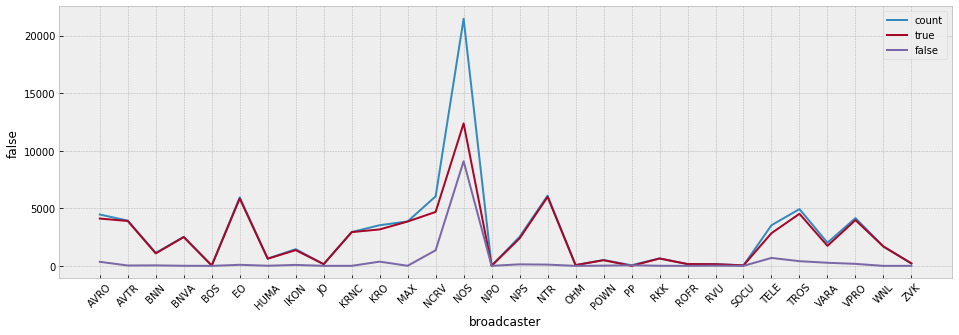

In [21]:
plt.figure(figsize = (16,5))
ax = sns.lineplot(x="broadcaster", y="count",data=pd_test, label="count")
ax = sns.lineplot(x="broadcaster", y="true",data=pd_test, label="true")
ax = sns.lineplot(x="broadcaster", y="false",data=pd_test, label="false")
plt.xticks(rotation=45)
plt.show()